In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.8.0+cu126
Torchvision: 0.23.0+cu126
CUDA: True Tesla T4
Classes: ['NORMAL', 'PNEUMONIA']
[01] train loss 0.1864 acc 0.927 f1 0.927 | val loss 0.1195 acc 1.000 f1 1.000 | 54.6s/epoch
[02] train loss 0.0839 acc 0.968 f1 0.967 | val loss 0.1281 acc 1.000 f1 1.000 | 47.1s/epoch
[03] train loss 0.0509 acc 0.984 f1 0.984 | val loss 0.0595 acc 1.000 f1 1.000 | 47.0s/epoch
[04] train loss 0.0494 acc 0.984 f1 0.983 | val loss 0.2165 acc 0.938 f1 0.937 | 48.2s/epoch
Early stopping at epoch 4 (best 1, F1=1.0000)
Best epoch: 1 Best Val F1: 1.0
Saved: artifacts/resnet50_finetune_best.pth


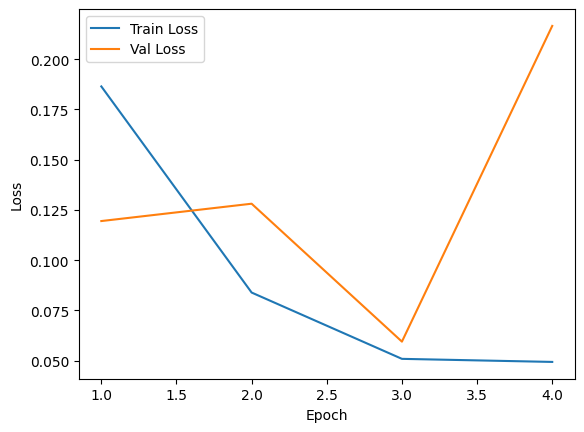

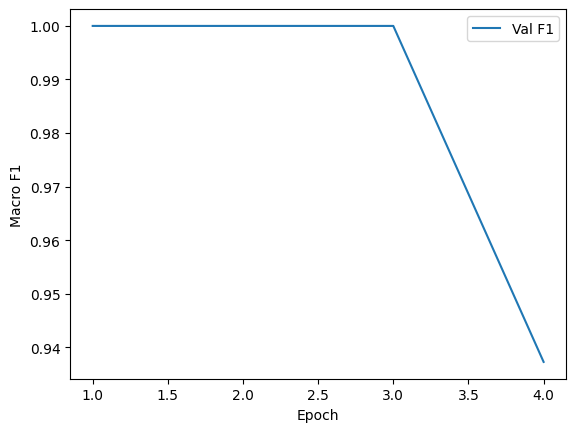

Test loss: 0.24613638333976268
Test acc : 0.9198717948717948
Test f1  : 0.9129464285714286
Confusion matrix:
 [[199  35]
 [ 15 375]]
              precision    recall  f1-score   support

      NORMAL     0.9299    0.8504    0.8884       234
   PNEUMONIA     0.9146    0.9615    0.9375       390

    accuracy                         0.9199       624
   macro avg     0.9223    0.9060    0.9129       624
weighted avg     0.9204    0.9199    0.9191       624



In [ ]:

# ResNet-50 Fine-Tuning


import os, sys, copy, json, time, numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from torch.amp import autocast, GradScaler

print("Python:", sys.version)
print("PyTorch:", torch.__version__)
import torchvision
print("Torchvision:", torchvision.__version__)
print("CUDA:", torch.cuda.is_available(), torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------ 設定 ------------------
data_dir = "/content/drive/MyDrive/生醫影像深度學習/Hw3"
img_size = 224
batch_size = 32
epochs = 15
patience = 3
num_workers = 2
seed = 2025
out_dir = Path("artifacts"); out_dir.mkdir(parents=True, exist_ok=True)

def set_seed(s=42):
    import random
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
set_seed(seed)

# ------------------ 資料 ------------------
train_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(7),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
eval_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder(os.path.join(data_dir,"train"), transform=train_tfms)
val_ds   = datasets.ImageFolder(os.path.join(data_dir,"val"),   transform=eval_tfms)
test_ds  = datasets.ImageFolder(os.path.join(data_dir,"test"),  transform=eval_tfms)
class_names = train_ds.classes
print("Classes:", class_names)

train_loader = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True)
val_loader   = DataLoader(val_ds,batch_size=batch_size,shuffle=False,num_workers=num_workers,pin_memory=True)
test_loader  = DataLoader(test_ds,batch_size=batch_size,shuffle=False,num_workers=num_workers,pin_memory=True)

# ------------------ 模型 ------------------
weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 2)
for p in model.parameters(): p.requires_grad = True
model = model.to(device)

# ------------------ 訓練設定 ------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = GradScaler(device="cuda" if torch.cuda.is_available() else "cpu", enabled=True)

def train_one_epoch(model, loader):
    model.train()
    losses, preds, gts = [], [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
            out = model(x)
            loss = criterion(out, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        losses.append(loss.item())
        preds.extend(out.detach().cpu().argmax(1).tolist())
        gts.extend(y.cpu().tolist())
    return np.mean(losses), accuracy_score(gts,preds), f1_score(gts,preds,average="macro")

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    losses, preds, gts = [], [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
            out = model(x)
            loss = criterion(out, y)
        losses.append(loss.item())
        preds.extend(out.cpu().argmax(1).tolist())
        gts.extend(y.cpu().tolist())
    return np.mean(losses), accuracy_score(gts,preds), f1_score(gts,preds,average="macro"), np.array(preds), np.array(gts)

# ------------------ 開始訓練 ------------------
history = []
best_f1, best_epoch, no_improve = -1.0, 0, 0
best_state = None

for epoch in range(1, epochs+1):
    t0 = time.time()
    tr_loss, tr_acc, tr_f1 = train_one_epoch(model, train_loader)
    va_loss, va_acc, va_f1, _, _ = evaluate(model, val_loader)
    dt = time.time() - t0

    history.append({"epoch":epoch,"train_loss":tr_loss,"train_acc":tr_acc,"train_f1":tr_f1,
                    "val_loss":va_loss,"val_acc":va_acc,"val_f1":va_f1})
    print(f"[{epoch:02d}] train loss {tr_loss:.4f} acc {tr_acc:.3f} f1 {tr_f1:.3f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.3f} f1 {va_f1:.3f} | {dt:.1f}s/epoch")

    if va_f1 > best_f1:
        best_f1, best_epoch, best_state, no_improve = va_f1, epoch, copy.deepcopy(model.state_dict()), 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch} (best {best_epoch}, F1={best_f1:.4f})")
            break

if best_state is not None:
    model.load_state_dict(best_state)
print("Best epoch:", best_epoch, "Best Val F1:", best_f1)

# ------------------ 儲存最佳模型 ------------------
ckpt_path = out_dir / "resnet50_finetune_best.pth"
torch.save({"state_dict":model.state_dict(),"best_epoch":best_epoch,"best_val_f1":best_f1,"classes":class_names}, ckpt_path)
print("Saved:", ckpt_path)

# ------------------ 畫出曲線 ------------------
epochs_r = [h["epoch"] for h in history]
plt.plot(epochs_r,[h["train_loss"] for h in history],label="Train Loss")
plt.plot(epochs_r,[h["val_loss"] for h in history],label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

plt.plot(epochs_r,[h["val_f1"] for h in history],label="Val F1")
plt.xlabel("Epoch"); plt.ylabel("Macro F1"); plt.legend(); plt.show()

# ------------------ 測試 ------------------
@torch.no_grad()
def test_report(model, loader, class_names):
    model.eval()
    loss, acc, f1, preds, gts = evaluate(model, loader)
    cm = confusion_matrix(gts, preds)
    print("Test loss:", loss)
    print("Test acc :", acc)
    print("Test f1  :", f1)
    print("Confusion matrix:\n", cm)
    print(classification_report(gts, preds, target_names=class_names, digits=4))
    return {"loss":loss,"acc":acc,"f1":f1,"cm":cm,"preds":preds,"gts":gts}

test_results = test_report(model, test_loader, class_names)


[01] TL 0.1407 A 0.945 F1 0.944 | VL 0.1230 A 1.000 F1 1.000 | 52.3s
[02] TL 0.0688 A 0.974 F1 0.973 | VL 0.0345 A 1.000 F1 1.000 | 49.3s
[03] TL 0.0483 A 0.981 F1 0.981 | VL 0.1586 A 0.938 F1 0.937 | 48.0s
[04] TL 0.0216 A 0.993 F1 0.993 | VL 0.1164 A 0.938 F1 0.937 | 49.5s
Early stop @ 4 (best 1, F1=1.0000)
Best epoch: 1 Best Val F1: 1.0
Test loss: 0.33512036092579367
Test acc : 0.8910256410256411
Test f1  : 0.8768058716960097



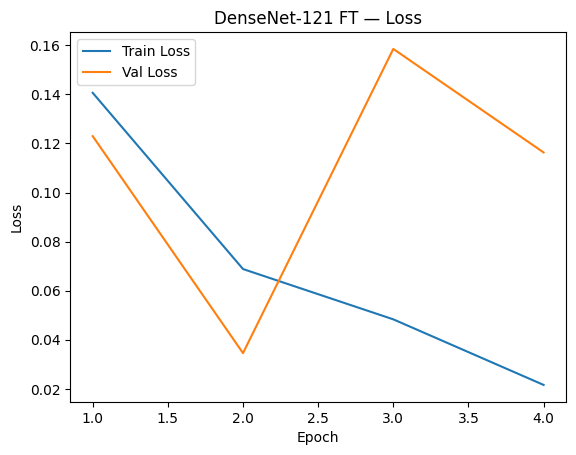

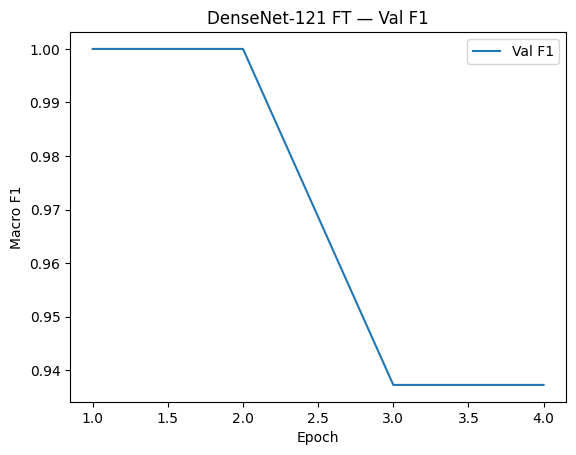

In [ ]:
# Task B – DenseNet-121 Fine-Tuning
import copy, numpy as np, torch, torch.nn as nn, torch.optim as optim, time
from torchvision import models
from torch.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt

weights = models.DenseNet121_Weights.IMAGENET1K_V1
d121 = models.densenet121(weights=weights)
d121.classifier = nn.Linear(d121.classifier.in_features, 2)
for p in d121.parameters(): p.requires_grad = True
d121 = d121.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(d121.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = GradScaler(device="cuda" if torch.cuda.is_available() else "cpu", enabled=True)

def train_epoch(model, loader):
    model.train()
    losses, preds, gts = [], [], []
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
            out = model(x); loss = criterion(out, y)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        losses.append(loss.item())
        preds.extend(out.detach().cpu().argmax(1).tolist())
        gts.extend(y.detach().cpu().tolist())
    return float(np.mean(losses)), accuracy_score(gts,preds), f1_score(gts,preds,average="macro")

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval()
    losses, preds, gts = [], [], []
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
            out = model(x); loss = criterion(out, y)
        losses.append(loss.item())
        preds.extend(out.detach().cpu().argmax(1).tolist())
        gts.extend(y.detach().cpu().tolist())
    return float(np.mean(losses)), accuracy_score(gts,preds), f1_score(gts,preds,average="macro")

history_d, best_f1, best_ep, no_imp = [], -1.0, 0, 0
best_state = None
epochs, patience = 15, 3

for ep in range(1, epochs+1):
    t0=time.time()
    trL,trA,trF = train_epoch(d121, train_loader)
    vaL,vaA,vaF = eval_epoch(d121, val_loader)
    dt=time.time()-t0
    history_d.append({"epoch":ep,"train_loss":trL,"train_acc":trA,"train_f1":trF,"val_loss":vaL,"val_acc":vaA,"val_f1":vaF})
    print(f"[{ep:02d}] TL {trL:.4f} A {trA:.3f} F1 {trF:.3f} | VL {vaL:.4f} A {vaA:.3f} F1 {vaF:.3f} | {dt:.1f}s")
    if vaF>best_f1: best_f1, best_ep, best_state, no_imp = vaF, ep, copy.deepcopy(d121.state_dict()), 0
    else:
        no_imp += 1
        if no_imp>=patience:
            print(f"Early stop @ {ep} (best {best_ep}, F1={best_f1:.4f})"); break

if best_state is not None: d121.load_state_dict(best_state)
print("Best epoch:", best_ep, "Best Val F1:", best_f1)

@torch.no_grad()
def test_report(model, loader, class_names):
    loss, acc, f1 = eval_epoch(model, loader)
    print("Test loss:", loss)
    print("Test acc :", acc)
    print("Test f1  :", f1)
    print(classification_report([], [], target_names=class_names, digits=4) if False else "")  # 佔位，不輸出混淆矩陣
    return {"loss":loss,"acc":acc,"f1":f1}

_ = test_report(d121, test_loader, class_names)

# 曲線圖
ep = [h["epoch"] for h in history_d]
trL = [h["train_loss"] for h in history_d]
vaL = [h["val_loss"]   for h in history_d]
vaF = [h["val_f1"]     for h in history_d]

plt.figure()
plt.plot(ep, trL, label="Train Loss")
plt.plot(ep, vaL, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("DenseNet-121 FT — Loss"); plt.legend(); plt.show()

plt.figure()
plt.plot(ep, vaF, label="Val F1")
plt.xlabel("Epoch"); plt.ylabel("Macro F1"); plt.title("DenseNet-121 FT — Val F1"); plt.legend(); plt.show()


[01] TL 0.3829 A 0.860 F1 0.860 | VL 0.4782 A 0.688 F1 0.676 | 55.0s
[02] TL 0.2630 A 0.898 F1 0.898 | VL 0.3684 A 0.875 F1 0.873 | 44.6s
[03] TL 0.2166 A 0.920 F1 0.920 | VL 0.3520 A 0.875 F1 0.875 | 46.2s
[04] TL 0.1997 A 0.931 F1 0.931 | VL 0.3657 A 0.812 F1 0.812 | 44.4s
[05] TL 0.1927 A 0.931 F1 0.931 | VL 0.3360 A 0.812 F1 0.812 | 44.8s
[06] TL 0.1774 A 0.930 F1 0.930 | VL 0.3912 A 0.750 F1 0.746 | 45.4s
Early stop @ 6 (best 3, F1=0.8750)
Best epoch: 3 Best Val F1: 0.875
Test loss: 0.3320138052105904
Test acc : 0.8701923076923077
Test f1  : 0.8601775444206845


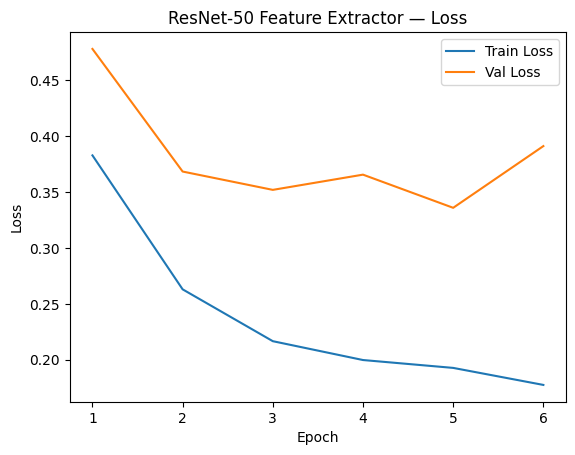

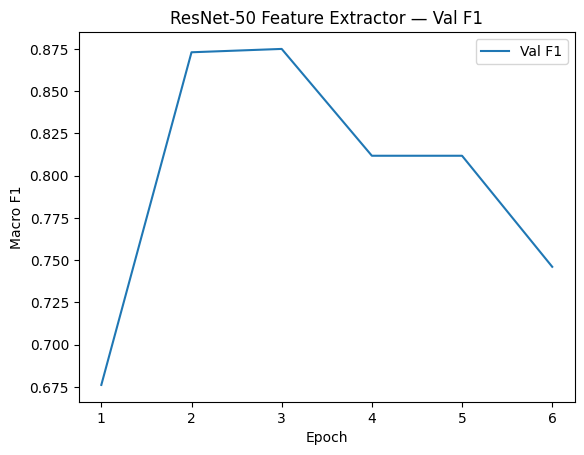

In [ ]:
# Task C – ResNet-50 Feature Extractor（含曲線與測試）
import os, sys, time, copy, numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from torch.amp import autocast, GradScaler

# device / dataloader
if 'device' not in globals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = globals().get('data_dir', "/content/drive/MyDrive/xray_2class")
img_size = 224; batch_size = 32; epochs = 15; patience = 3; num_workers = 2; seed = 2025
def set_seed(s=42):
    import random
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = False; torch.backends.cudnn.benchmark = True
set_seed(seed)
need_build = any(n not in globals() for n in ['train_loader','val_loader','test_loader','class_names'])
if need_build:
    t_train = transforms.Compose([transforms.Resize((img_size,img_size)),transforms.RandomHorizontalFlip(0.5),
                                  transforms.RandomRotation(7),transforms.ToTensor(),
                                  transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
    t_eval  = transforms.Compose([transforms.Resize((img_size,img_size)),transforms.ToTensor(),
                                  transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
    train_ds = datasets.ImageFolder(os.path.join(data_dir,"train"), t_train)
    val_ds   = datasets.ImageFolder(os.path.join(data_dir,"val"),   t_eval)
    test_ds  = datasets.ImageFolder(os.path.join(data_dir,"test"),  t_eval)
    class_names = train_ds.classes
    from torch.utils.data import DataLoader
    train_loader = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True)
    val_loader   = DataLoader(val_ds,  batch_size=batch_size,shuffle=False,num_workers=num_workers,pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=batch_size,shuffle=False,num_workers=num_workers,pin_memory=True)

# model（凍結骨幹）
weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights)
for p in model.parameters(): p.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 2)  # 只訓這層
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)  # 只給 head
scaler = GradScaler(device="cuda" if torch.cuda.is_available() else "cpu", enabled=True)

def train_epoch_fe(model, loader):
    model.train()
    losses, preds, gts = [], [], []
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
            out = model(x); loss = criterion(out,y)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        losses.append(loss.item()); preds.extend(out.detach().cpu().argmax(1).tolist()); gts.extend(y.detach().cpu().tolist())
    return float(np.mean(losses)), accuracy_score(gts,preds), f1_score(gts,preds,average="macro")

@torch.no_grad()
def eval_epoch_fe(model, loader):
    model.eval()
    losses, preds, gts = [], [], []
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
            out = model(x); loss = criterion(out,y)
        losses.append(loss.item()); preds.extend(out.detach().cpu().argmax(1).tolist()); gts.extend(y.detach().cpu().tolist())
    return float(np.mean(losses)), accuracy_score(gts,preds), f1_score(gts,preds,average="macro")

hist_r50fe, best_f1, best_ep, no_imp = [], -1., 0, 0
best_state = None
for ep in range(1, epochs+1):
    t0=time.time()
    trL,trA,trF = train_epoch_fe(model, train_loader)
    vaL,vaA,vaF = eval_epoch_fe(model, val_loader)
    dt=time.time()-t0
    hist_r50fe.append({"epoch":ep,"train_loss":trL,"train_acc":trA,"train_f1":trF,"val_loss":vaL,"val_acc":vaA,"val_f1":vaF})
    print(f"[{ep:02d}] TL {trL:.4f} A {trA:.3f} F1 {trF:.3f} | VL {vaL:.4f} A {vaA:.3f} F1 {vaF:.3f} | {dt:.1f}s")
    if vaF>best_f1: best_f1,best_ep,best_state,no_imp = vaF,ep,copy.deepcopy(model.state_dict()),0
    else:
        no_imp+=1
        if no_imp>=patience: print(f"Early stop @ {ep} (best {best_ep}, F1={best_f1:.4f})"); break

if best_state is not None: model.load_state_dict(best_state)
print("Best epoch:", best_ep, "Best Val F1:", best_f1)

@torch.no_grad()
def test_report_fe(model, loader):
    L,A,F = eval_epoch_fe(model, loader)
    print("Test loss:", L); print("Test acc :", A); print("Test f1  :", F)
    return {"loss":L,"acc":A,"f1":F}
_ = test_report_fe(model, test_loader)

# 曲線
ep = [h["epoch"] for h in hist_r50fe]
plt.figure(); plt.plot(ep,[h["train_loss"] for h in hist_r50fe],label="Train Loss"); plt.plot(ep,[h["val_loss"] for h in hist_r50fe],label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("ResNet-50 Feature Extractor — Loss"); plt.legend(); plt.show()
plt.figure(); plt.plot(ep,[h["val_f1"] for h in hist_r50fe],label="Val F1")
plt.xlabel("Epoch"); plt.ylabel("Macro F1"); plt.title("ResNet-50 Feature Extractor — Val F1"); plt.legend(); plt.show()


[01] TL 0.3863 A 0.865 F1 0.865 | VL 0.3365 A 0.875 F1 0.873 | 50.8s
[02] TL 0.2398 A 0.911 F1 0.911 | VL 0.2287 A 0.938 F1 0.937 | 47.2s
[03] TL 0.2204 A 0.914 F1 0.914 | VL 0.2208 A 0.938 F1 0.937 | 45.0s
[04] TL 0.1940 A 0.930 F1 0.930 | VL 0.1863 A 0.938 F1 0.937 | 43.9s
[05] TL 0.1937 A 0.932 F1 0.932 | VL 0.1775 A 0.938 F1 0.937 | 46.4s
Early stop @ 5 (best 2, F1=0.9373)
Best epoch: 2 Best Val F1: 0.9372549019607843
Test loss: 0.32237536609172823
Test acc : 0.8493589743589743
Test f1  : 0.8305288461538461


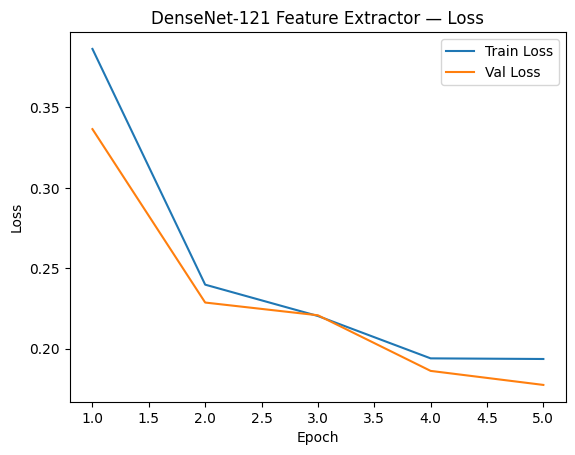

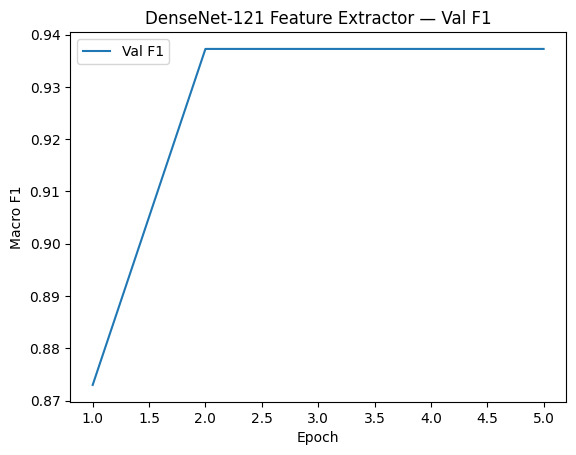

In [ ]:
# Task C – DenseNet-121 Feature Extractor（含曲線與測試）
import os, sys, time, copy, numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from torch.amp import autocast, GradScaler

if 'device' not in globals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = globals().get('data_dir', "/content/drive/MyDrive/xray_2class")
img_size = 224; batch_size = 32; epochs = 15; patience = 3; num_workers = 2; seed = 2025
def set_seed(s=42):
    import random
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = False; torch.backends.cudnn.benchmark = True
set_seed(seed)
need_build = any(n not in globals() for n in ['train_loader','val_loader','test_loader','class_names'])
if need_build:
    t_train = transforms.Compose([transforms.Resize((img_size,img_size)),transforms.RandomHorizontalFlip(0.5),
                                  transforms.RandomRotation(7),transforms.ToTensor(),
                                  transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
    t_eval  = transforms.Compose([transforms.Resize((img_size,img_size)),transforms.ToTensor(),
                                  transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
    train_ds = datasets.ImageFolder(os.path.join(data_dir,"train"), t_train)
    val_ds   = datasets.ImageFolder(os.path.join(data_dir,"val"),   t_eval)
    test_ds  = datasets.ImageFolder(os.path.join(data_dir,"test"),  t_eval)
    class_names = train_ds.classes
    train_loader = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True)
    val_loader   = DataLoader(val_ds,  batch_size=batch_size,shuffle=False,num_workers=num_workers,pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=batch_size,shuffle=False,num_workers=num_workers,pin_memory=True)

weights = models.DenseNet121_Weights.IMAGENET1K_V1
model = models.densenet121(weights=weights)
for p in model.parameters(): p.requires_grad = False
model.classifier = nn.Linear(model.classifier.in_features, 2)  # 只訓這層
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.classifier.parameters(), lr=1e-3, weight_decay=1e-4)
scaler = GradScaler(device="cuda" if torch.cuda.is_available() else "cpu", enabled=True)

def train_epoch_fe(model, loader):
    model.train()
    losses, preds, gts = [], [], []
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
            out = model(x); loss = criterion(out,y)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        losses.append(loss.item()); preds.extend(out.detach().cpu().argmax(1).tolist()); gts.extend(y.detach().cpu().tolist())
    return float(np.mean(losses)), accuracy_score(gts,preds), f1_score(gts,preds,average="macro")

@torch.no_grad()
def eval_epoch_fe(model, loader):
    model.eval()
    losses, preds, gts = [], [], []
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
            out = model(x); loss = criterion(out,y)
        losses.append(loss.item()); preds.extend(out.detach().cpu().argmax(1).tolist()); gts.extend(y.detach().cpu().tolist())
    return float(np.mean(losses)), accuracy_score(gts,preds), f1_score(gts,preds,average="macro")

hist_d121fe, best_f1, best_ep, no_imp = [], -1., 0, 0
best_state = None
for ep in range(1, epochs+1):
    t0=time.time()
    trL,trA,trF = train_epoch_fe(model, train_loader)
    vaL,vaA,vaF = eval_epoch_fe(model, val_loader)
    dt=time.time()-t0
    hist_d121fe.append({"epoch":ep,"train_loss":trL,"train_acc":trA,"train_f1":trF,"val_loss":vaL,"val_acc":vaA,"val_f1":vaF})
    print(f"[{ep:02d}] TL {trL:.4f} A {trA:.3f} F1 {trF:.3f} | VL {vaL:.4f} A {vaA:.3f} F1 {vaF:.3f} | {dt:.1f}s")
    if vaF>best_f1: best_f1,best_ep,best_state,no_imp = vaF,ep,copy.deepcopy(model.state_dict()),0
    else:
        no_imp+=1
        if no_imp>=patience: print(f"Early stop @ {ep} (best {best_ep}, F1={best_f1:.4f})"); break

if best_state is not None: model.load_state_dict(best_state)
print("Best epoch:", best_ep, "Best Val F1:", best_f1)

@torch.no_grad()
def test_report_fe(model, loader):
    L,A,F = eval_epoch_fe(model, loader)
    print("Test loss:", L); print("Test acc :", A); print("Test f1  :", F)
    return {"loss":L,"acc":A,"f1":F}
_ = test_report_fe(model, test_loader)

# 曲線
ep = [h["epoch"] for h in hist_d121fe]
plt.figure(); plt.plot(ep,[h["train_loss"] for h in hist_d121fe],label="Train Loss"); plt.plot(ep,[h["val_loss"] for h in hist_d121fe],label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("DenseNet-121 Feature Extractor — Loss"); plt.legend(); plt.show()
plt.figure(); plt.plot(ep,[h["val_f1"] for h in hist_d121fe],label="Val F1")
plt.xlabel("Epoch"); plt.ylabel("Macro F1"); plt.title("DenseNet-121 Feature Extractor — Val F1"); plt.legend(); plt.show()
